In [1]:
%load_ext autoreload
%autoreload 2

In [12]:
from hw2_3 import *
import torch
from tqdm.notebook import tqdm
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt 

In [6]:
batch_size = 256
lr = 4e-4
epochs = 100

mnist_train = loadData('hw2_data/digits/mnistm/train.csv',batch_size,4)
mnist_val = loadData('hw2_data/digits/mnistm/val.csv',batch_size,4)
svhn_train = loadData('hw2_data/digits/svhn/train.csv',batch_size,4,drop=True)
svhn_val = loadData('hw2_data/digits/svhn/val.csv',batch_size,4)
usps_train = loadData('hw2_data/digits/usps/train.csv',batch_size,4,drop=True)
usps_val = loadData('hw2_data/digits/usps/val.csv',batch_size,4)

F = FeatureExtractor().cuda()
C = Classifier().cuda()
D = Discriminator().cuda()

bce = nn.BCELoss()
loss_func = nn.CrossEntropyLoss()

F_opt = torch.optim.Adam(F.parameters(), lr = lr)
C_opt = torch.optim.Adam(C.parameters(), lr = lr)
D_opt = torch.optim.Adam(D.parameters(), lr = lr)

D_src = torch.ones(batch_size, 1).cuda() # Discriminator Label to real
D_tgt = torch.zeros(batch_size, 1).cuda() # Discriminator Label to fake
D_labels = torch.cat([D_src, D_tgt], dim=0)

In [7]:
def val(dataloader):
    F.eval()
    C.eval()
    with torch.no_grad():
        correct = torch.zeros(1).cuda()
        for img,label in dataloader:
            img,label = img.cuda(),label.cuda()
            pred = C(F(img))
            _, pred = torch.max(pred,1)
            correct += (pred == label).sum()
    acc = correct.item() / len( dataloader.dataset )
    print(f'val acc:{acc:.4f}')
    return acc

In [8]:
def get_lambda(epoch, max_epoch):
    p = epoch / max_epoch
    return 2. / (1+np.exp(-10.*p)) - 1.

In [18]:
for epoch in range(epochs):
    bar = tqdm(mnist_train)
    svhn = iter(svhn_train)
    
    F.train()
    C.train()
    D.train()
    
    for image, label in bar:
        try:
            newimg, _ = next(svhn)
        except StopIteration:
            svhn = iter(svhn_train)
            newimg, _ = next(svhn)
            
        image, label, newimg = image.cuda(),label.cuda(),newimg.cuda()
        
        x = torch.cat([image,newimg],dim=0)
        feature = F(x)
        D_pred = D( feature.detach() )
        D_loss = bce(D_pred,D_labels)
        
        D.zero_grad()
        D_loss.backward()
        D_opt.step()
        
        pred = C(feature[:batch_size])
        D_pred = D(feature)
        loss = loss_func(pred,label)
        D_loss = bce(D_pred,D_labels)
        lamda = get_lambda(epoch,epochs)
        Ltot = loss - lamda * D_loss * 0.3
        
        F.zero_grad()
        C.zero_grad()
        D.zero_grad()
        
        Ltot.backward()
        
        C_opt.step()
        F_opt.step()
        
        bar.set_description(f"loss: {Ltot:.4f}")
    print('Epoch:',epoch)
    acc = val(svhn_val)
    aaa = val(mnist_val)
    if acc>=0.48 :
        print("Got enough acc")
        break

  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 0
val acc:0.4718
val acc:0.9057


  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 1
val acc:0.4793
val acc:0.9087


  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 2
val acc:0.4758
val acc:0.9121


  0%|          | 0/175 [00:00<?, ?it/s]

Epoch: 3
val acc:0.4881
val acc:0.9116
Got enough acc


In [24]:
def saveModel():
    Fpath = "./hw2_3_svhn_F1.pth"
    Cpath = "./hw2_3_svhn_C1.pth"
    torch.save(F.state_dict(), Fpath)
    torch.save(C.state_dict(), Cpath)

In [25]:
saveModel()

/home/heisenberg/.venvs/DLCVenv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/heisenberg/.venvs/DLCVenv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


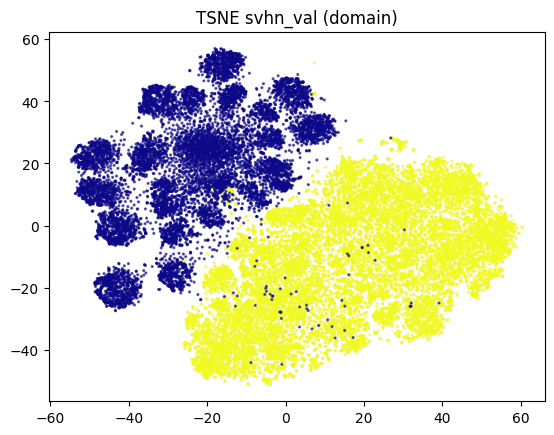

In [37]:
def tsne(val_loader,src_loader=None):
    F.eval()
    start = 1
    with torch.no_grad():
        for img, label in val_loader :
            output_tsne = F(img.cuda()).cpu().detach().numpy()
            if src_loader:
                labels = np.ones(img.shape[0])
            else:
                labels = label.cpu().detach().numpy()
            if start :
                tsne_data = output_tsne
                label_data = labels
                start = 0
            else:
                tsne_data = np.concatenate((tsne_data,output_tsne),axis=0)
                label_data = np.concatenate((label_data,labels),axis=0)
        if src_loader:
            for img, label in src_loader :
                output_tsne = F(img.cuda()).cpu().detach().numpy()
                labels = np.zeros(img.shape[0])
                tsne_data = np.concatenate((tsne_data,output_tsne),axis=0)
                label_data = np.concatenate((label_data,labels),axis=0)
                
    x = TSNE(n_components = 2, perplexity = 45, n_iter = 1000,init='pca').fit_transform(tsne_data.squeeze())
    plt.title('TSNE svhn_val (domain)')
#     x_min, x_max = x.min(0), x.max(0)
#     X_norm = (x - x_min) / (x_max - x_min)
    plt.scatter(x[:,0],x[:,1],c=label_data,cmap='plasma',alpha=0.6,s=np.pi*0.5)

tsne(svhn_val,mnist_val)